In [9]:
import keras
import pathlib
import soundfile
import librosa.display
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [10]:
DATASET_PATH = "data"

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    # from google.colab import drive
    print("Data not found")

In [11]:
def load_data(data_dir):
    data = []
    labels = []
    sample_rate = []
    # Iterate over all the files of the directory it has two subdirectories with the labels
    for _, dir in enumerate(data_dir.iterdir()):
        for file in dir.iterdir():
            audio, sr = soundfile.read(file)
            sample_rate.append(sr)
            data.append(audio)
            labels.append(str(dir).split("/")[-1])

    return data, np.array(sample_rate), np.array(labels)

data, sample_rate, labels = load_data(data_dir)
sample_rate = np.unique(sample_rate)[0]
print("Sample rate: ", sample_rate)

Sample rate:  8000


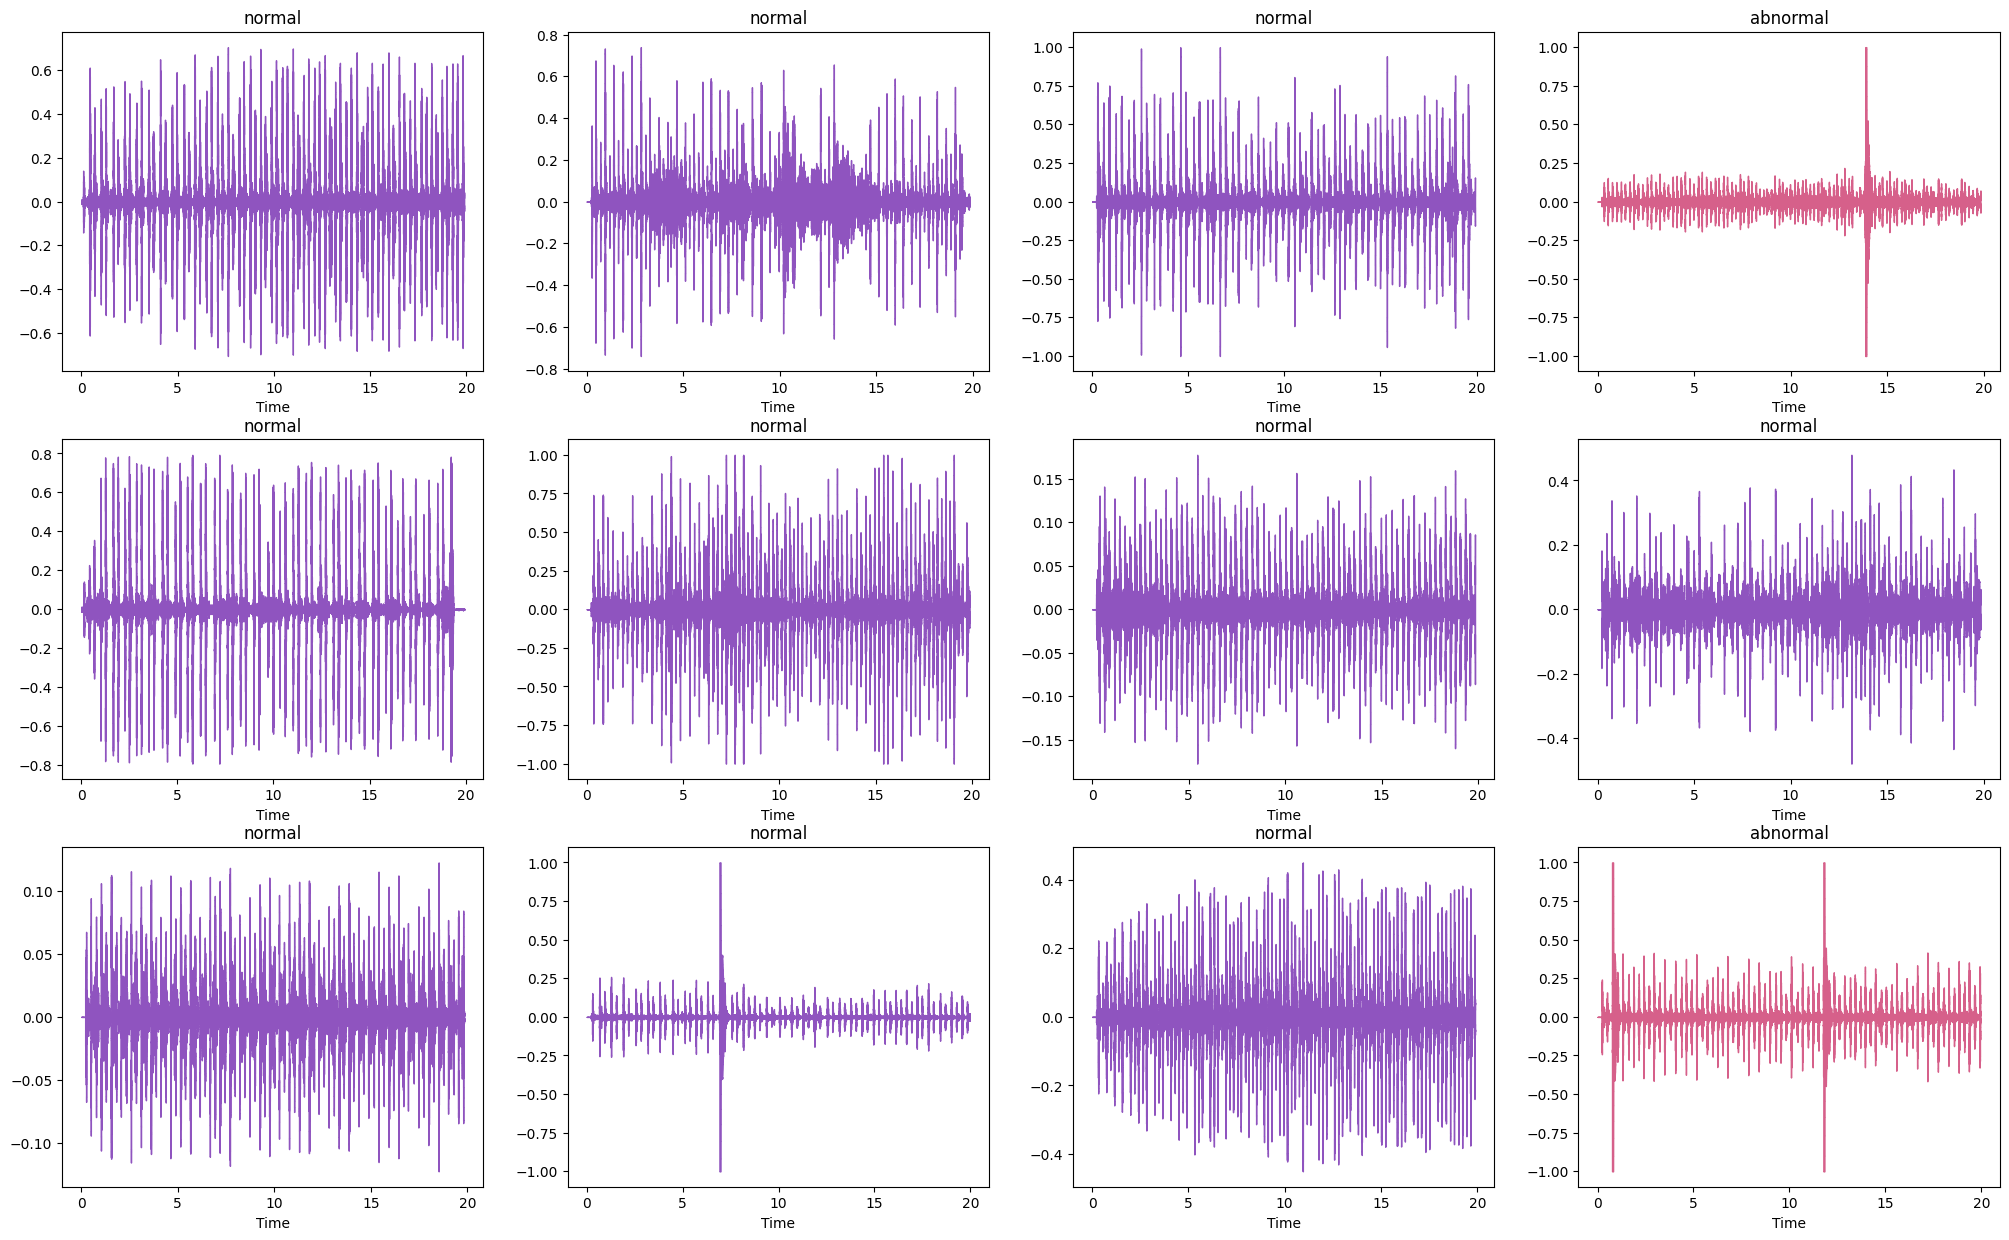

In [12]:
fig, axes = plt.subplots(3, 4, figsize=(25, 15))
for i in range(12):
    ax = axes[i // 4, i % 4]
    # create a random index
    idx = np.random.randint(len(data))
    color = '#8f54bf' if labels[idx] == 'normal' else '#d6608a'
    plt.subplot(3, 4, i+1)
    librosa.display.waveshow(data[idx], sr=sample_rate, ax=ax, color=color)
    ax.set_title(labels[idx])
plt.show()

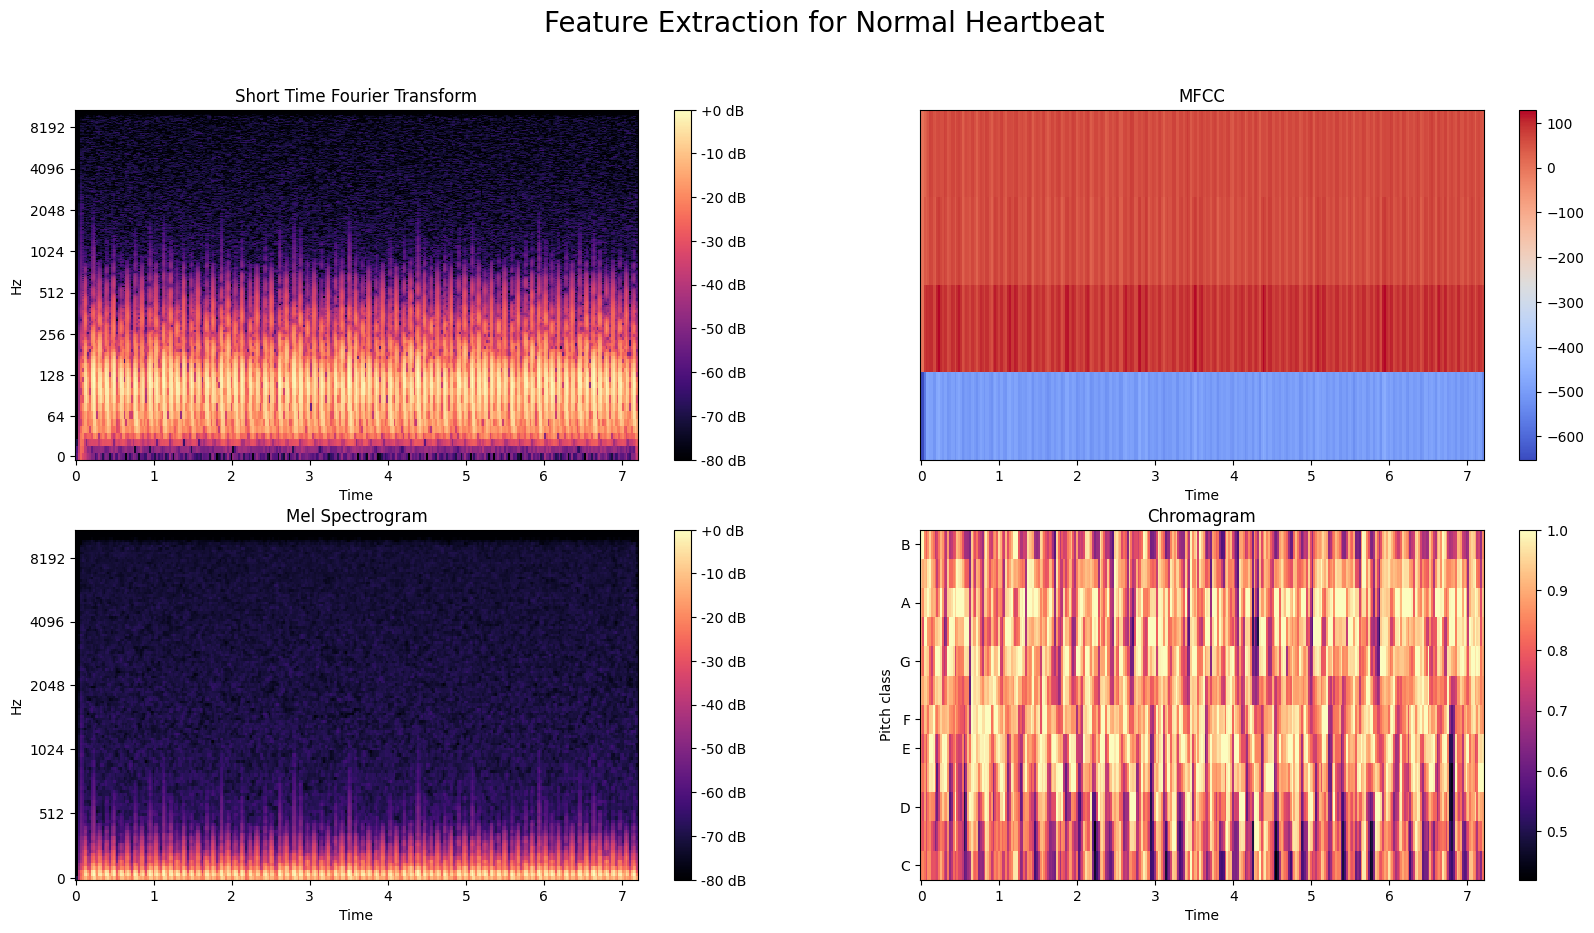

In [13]:
# Plot STFT, MFCC, Mel Spectrogram and Chromagram for a normal heartbeat
normal_audio = data[np.random.choice(np.where(labels == 'normal')[0])]
fig, _ = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Feature Extraction for Normal Heartbeat', fontsize=20)

# STFT for normal heartbeat
plt.subplot(2, 2, 1)
stft = np.abs(librosa.stft(normal_audio))
librosa.display.specshow(librosa.amplitude_to_db(stft, ref=np.max), y_axis='log', x_axis='time')
plt.title('Short Time Fourier Transform')
plt.colorbar(format='%+2.0f dB')

# MFCC for normal heartbeat ( Uses STFT and Mel Spectrogram and Discrete Cosine Transform )
plt.subplot(2, 2, 2)
mfccs = librosa.feature.mfcc(y=normal_audio, sr=sample_rate, n_mfcc=4)
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')

# Mel Spectrogram for normal heartbeat ( Uses STFT )
plt.subplot(2, 2, 3)
mel_spectrogram = librosa.feature.melspectrogram(y=normal_audio, sr=sample_rate)
librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')

# Chromagram for normal heartbeat ( Uses STFT and classifies to 12 pitch classes)
plt.subplot(2, 2, 4)
chromagram = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')

plt.show()

Text(0.5, 1.0, 'Chromagram')

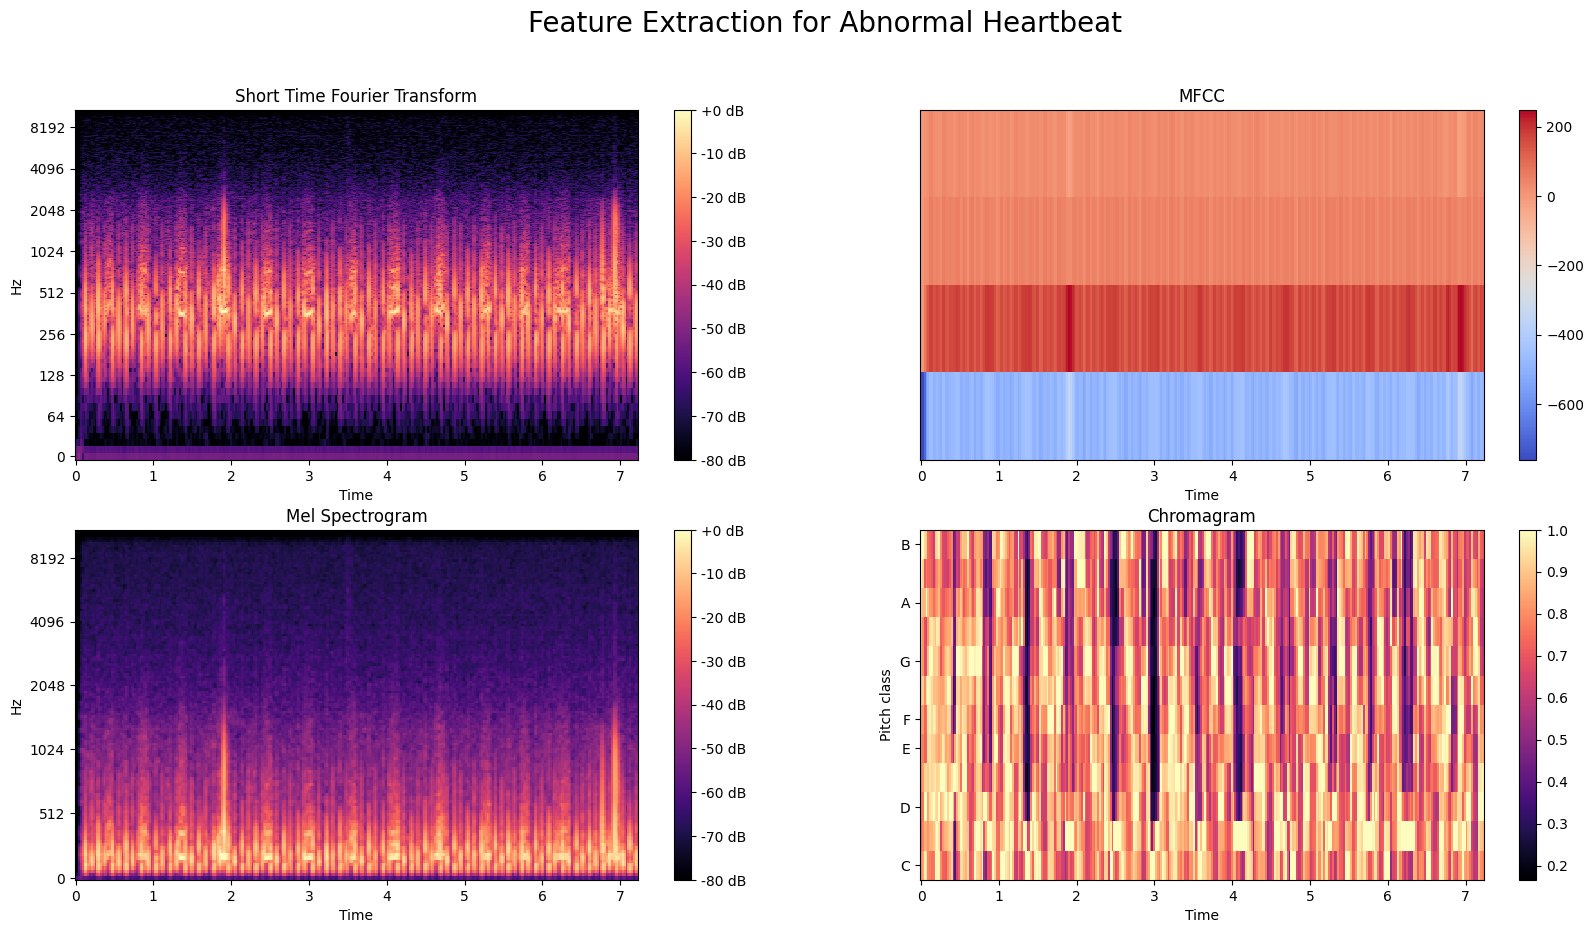

In [14]:
# STFT, MFCC, Mel Spectrogram and Chromagram for an abnormal heartbeat
abnormal_audio = data[np.random.choice(np.where(labels == 'abnormal')[0])]
fig, _ = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Feature Extraction for Abnormal Heartbeat', fontsize=20)

# STFT for abnormal heartbeat
plt.subplot(2, 2, 1)
stft = np.abs(librosa.stft(abnormal_audio))
librosa.display.specshow(librosa.amplitude_to_db(stft, ref=np.max), y_axis='log', x_axis='time')
plt.title('Short Time Fourier Transform')
plt.colorbar(format='%+2.0f dB')

# MFCC for abnormal heartbeat ( Uses STFT and Mel Spectrogram and Discrete Cosine Transform )
plt.subplot(2, 2, 2)
mfccs = librosa.feature.mfcc(y=abnormal_audio, sr=sample_rate, n_mfcc=4)
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')

# Mel Spectrogram for abnormal heartbeat ( Uses STFT )
plt.subplot(2, 2, 3)
mel_spectrogram = librosa.feature.melspectrogram(y=abnormal_audio, sr=sample_rate)
librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')

# Chromagram for abnormal heartbeat ( Uses STFT and classifies to 12 pitch classes)
plt.subplot(2, 2, 4)
chromagram = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')

In [15]:
# Extracting Features using Short Time Fourier Transform, MFCC, Mel Spectrogram and Chromagram
def extract_features(data, print_string="Extracting Features"):
    stft_features = []
    mfcc_features = []
    mel_spectrogram_features = []
    chromagram_features = []

    for audio in data:
        stft = np.abs(librosa.stft(audio))
        stft_features.append(np.mean(stft))
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=4).T, axis=0)
        mfcc_features.append(mfccs)
        mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=audio, sr=sample_rate).T, axis=0)
        mel_spectrogram_features.append(mel_spectrogram)
        chromagram = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        chromagram_features.append(chromagram)

    print(f'{print_string} Done: STFT: {stft_features[0].shape}, MFCC: {mfcc_features[0].shape}, Mel Spectrogram: {mel_spectrogram_features[0].shape}, Chromagram: {chromagram_features[0].shape}')
    return np.hstack((np.array(stft_features).reshape(-1, 1), np.array(mfcc_features), np.array(mel_spectrogram_features), np.array(chromagram_features)))

features = extract_features(data)

/home/shurtu-gal/Stuff/Course/env/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Extracting Features Done: STFT: (), MFCC: (4,), Mel Spectrogram: (128,), Chromagram: (12,)


We are getting 128 features from Mel spectrogram, 12 features from Chromagram, 4 features from MFCC and 1 feature from STFT.

In [16]:
print(f'\nAudio samples represented: {features.shape[0]}')
print(f'Number of features per sample: {features[0].shape[0]}')

features_df = pd.DataFrame(features)
# put labels in the dataframe
features_df['labels'] = labels
features_df



Audio samples represented: 941
Number of features per sample: 145


,0,1,2,3,4,5,6,7,8,9,...,136,137,138,139,140,141,142,143,144,labels
0,0.691779,-445.917560,124.894577,105.858306,82.328009,323.208732,314.995335,285.497579,128.551109,69.905276,...,0.786897,0.811428,0.812425,0.827670,0.853494,0.833571,0.830033,0.759326,0.734262,abnormal
1,0.104989,-543.254951,76.915047,64.455639,55.119032,15.137329,48.228177,13.787999,2.593586,0.518960,...,0.901348,0.879527,0.848596,0.815725,0.824301,0.823366,0.842112,0.820146,0.798278,abnormal
2,0.327218,-477.035211,104.366764,86.412671,65.246083,142.176635,222.887987,72.367156,11.737448,6.247238,...,0.839162,0.845296,0.879601,0.907662,0.931286,0.887555,0.840171,0.793226,0.789012,abnormal
3,0.120382,-473.492828,170.907562,78.196438,34.087026,0.002954,0.039862,0.139120,0.327778,1.130610,...,0.823557,0.820334,0.757678,0.736806,0.737603,0.728720,0.733694,0.744729,0.762422,abnormal
4,0.764708,-406.393048,117.633360,88.228383,69.048138,297.916299,708.853858,619.938146,190.810301,32.401626,...,0.799441,0.782194,0.769645,0.763495,0.792885,0.816260,0.849636,0.849345,0.859289,abnormal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,0.518702,-435.370961,84.744198,70.979093,60.580513,196.525805,408.063642,358.654179,96.698566,33.696291,...,0.781631,0.772937,0.775678,0.785341,0.847947,0.877254,0.909303,0.898008,0.881652,normal
937,0.198107,-448.460899,67.697377,62.023055,56.129308,56.454010,62.827512,29.446284,11.986245,8.612242,...,0.824043,0.864386,0.854126,0.870649,0.890749,0.872707,0.837496,0.775897,0.742043,normal
938,0.288730,-484.315026,92.656334,80.614944,66.956742,0.611931,61.202166,195.302864,113.702823,27.052174,...,0.803293,0.745456,0.705243,0.715565,0.749274,0.769001,0.800135,0.795480,0.802429,normal
939,0.083116,-507.360044,75.625896,46.555308,53.254318,11.025193,13.552606,2.558539,0.907022,0.636251,...,0.823664,0.818510,0.859938,0.913137,0.894815,0.899152,0.885315,0.831481,0.793247,normal


### Preprocesssing

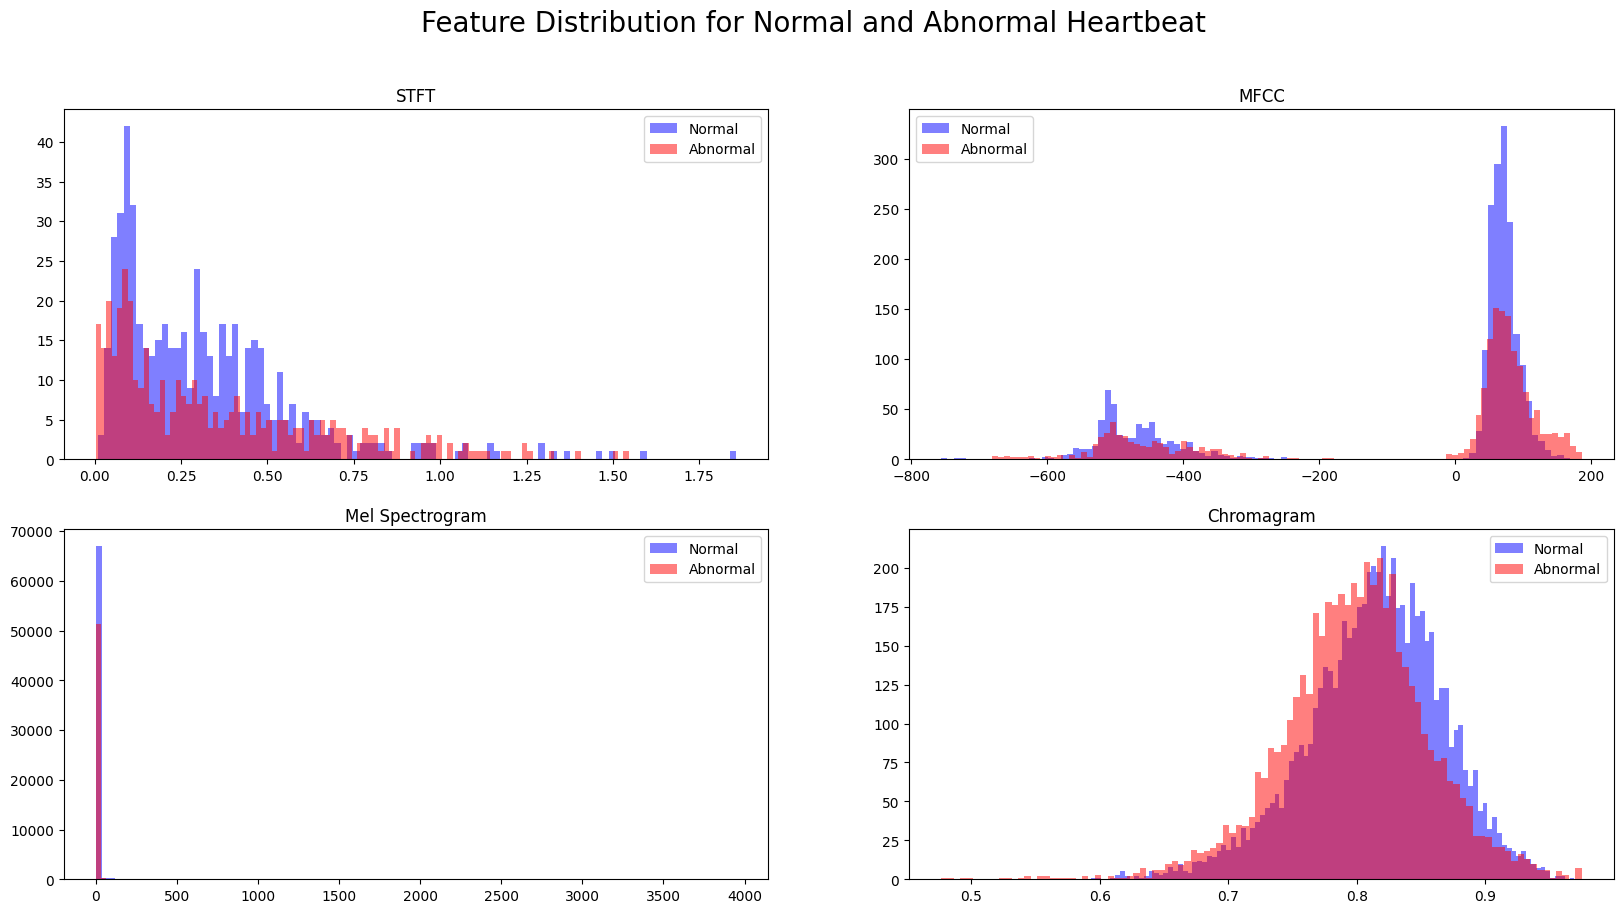

In [17]:
# Check feature distribution for each label
normal_features = np.array(features_df[features_df['labels'] == 'normal'].drop('labels', axis=1))
abnormal_features = np.array(features_df[features_df['labels'] == 'abnormal'].drop('labels', axis=1))

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Feature Distribution for Normal and Abnormal Heartbeat', fontsize=20)


# STFT
plt.subplot(2, 2, 1)
plt.title('STFT')
plt.hist(normal_features[:, 0], bins=100, alpha=0.5, color='b', label='Normal')
plt.hist(abnormal_features[:, 0], bins=100, alpha=0.5, color='r', label='Abnormal')
plt.legend()

# MFCC
plt.subplot(2, 2, 2)
plt.title('MFCC')
plt.hist(normal_features[:, 1:5].flatten(), bins=100, alpha=0.5, color='b', label='Normal')
plt.hist(abnormal_features[:, 1:5].flatten(), bins=100, alpha=0.5, color='r', label='Abnormal')
plt.legend()

# Mel Spectrogram
plt.subplot(2, 2, 3)
plt.title('Mel Spectrogram')
plt.hist(normal_features[:, 5:133].flatten(), bins=100, alpha=0.5, color='b', label='Normal')
plt.hist(abnormal_features[:, 5:133].flatten(), bins=100, alpha=0.5, color='r', label='Abnormal')
plt.legend()

# Chromagram
plt.subplot(2, 2, 4)
plt.title('Chromagram')
plt.hist(normal_features[:, 133:].flatten(), bins=100, alpha=0.5, color='b', label='Normal')
plt.hist(abnormal_features[:, 133:].flatten(), bins=100, alpha=0.5, color='r', label='Abnormal')
plt.legend()

plt.show()

In [18]:
# Get parameters for the STFT, MFCC, Mel Spectrogram and Chromagram features (mean, std, min, max)
def print_params(features_df):
    features_df_stft = features_df.loc[:, :0]
    features_df_mfcc = features_df.loc[:, 1:4]
    features_df_mel_spectrogram = features_df.loc[:, 5:132]
    features_df_chromagram = features_df.loc[:, 133:144]

    print(f'STFT Features: mean: {features_df_stft.stack().mean()},  std: {features_df_stft.stack().std()}, min: {features_df_stft.min().min()}, max: {features_df_stft.max().max()}')
    print(f'MFCC Features: mean: {features_df_mfcc.stack().mean()}, std: {features_df_mfcc.stack().std()}, min: {features_df_mfcc.min().min()}, max: {features_df_mfcc.max().max()}')
    print(f'Mel Spectrogram Features: mean: {features_df_mel_spectrogram.stack().mean()}, std: {features_df_mel_spectrogram.stack().std()}, min: {features_df_mel_spectrogram.min().min()}, max: {features_df_mel_spectrogram.max().max()}')
    print(f'Chromagram Features: mean: {features_df_chromagram.stack().mean()}, std: {features_df_chromagram.stack().std()}, min: {features_df_chromagram.min().min()}, max: {features_df_chromagram.max().max()}')

In [19]:
# Feature Scaling and Normalization
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

print('Parameters before scaling and normalization:')
print_params(features_df)

scaler = StandardScaler()
features_scaled = features.copy()
features_scaled[:, :1] = scaler.fit_transform(features[:, :1])

scaler = MinMaxScaler()
features_minmax = features.copy()
features_minmax[:, :1] = scaler.fit_transform(features[:, :1])

print('\nParameters after scaling and normalization:')
print_params(pd.DataFrame(features_scaled))

print('\nParameters after MinMax scaling:')
print_params(pd.DataFrame(features_minmax))

Parameters before scaling and normalization:
STFT Features: mean: 0.3320191894084279,  std: 0.28876118319649335, min: 0.0025506824156082343, max: 1.8567575058160326
MFCC Features: mean: -60.042993066858116, std: 238.6651397880534, min: -756.3430815899292, max: 185.44166468810982
Mel Spectrogram Features: mean: 5.044508511276835, std: 59.50858103947214, min: 1.6350441871479257e-08, max: 3947.7352494032425
Chromagram Features: mean: 0.8074275575493456, std: 0.05532479201870964, min: 0.47660524941487403, max: 0.9750175787461421

Parameters after scaling and normalization:
STFT Features: mean: -7.550932367269927e-18,  std: 1.0005317735020882, min: -1.1415790237647638, max: 5.283082424564656
MFCC Features: mean: -60.042993066858116, std: 238.6651397880534, min: -756.3430815899292, max: 185.44166468810982
Mel Spectrogram Features: mean: 5.044508511276835, std: 59.50858103947214, min: 1.6350441871479257e-08, max: 3947.7352494032425
Chromagram Features: mean: 0.8074275575493456, std: 0.0553247

In [34]:
# Train and Test Split [8, 2]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

print(f'X_train: {X_train.shape}, y_train: {len(y_train)}')
print(f'X_test: {X_test.shape}, y_test: {len(y_test)}')

X_train: (752, 145), y_train: 752
X_test: (189, 145), y_test: 189


In [21]:
# 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classification_models = [
    KNeighborsClassifier(),#(3),
    SVC(kernel='linear'),#, C=0.025),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),#max_depth=5),
    RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scores = []
for model2 in classification_models:
    model2.fit(X_train, y_train)
    score = model2.score(X_test, y_test)
    model_name = type(model2).__name__
    if model_name=='SVC' and model2.kernel=='rbf': model_name+=' RBF kernel'
    scores.append((model_name,(f'{100*score:.2f}%')))

scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score'])
scores_df.sort_values(by='Accuracy Score',axis=0,ascending=False)

/home/shurtu-gal/Stuff/Course/env/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/shurtu-gal/Stuff/Course/env/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,Classifier,Accuracy Score
5,AdaBoostClassifier,81.48%
4,RandomForestClassifier,80.42%
1,SVC,78.84%
0,KNeighborsClassifier,71.43%
2,SVC RBF kernel,70.37%
3,DecisionTreeClassifier,69.84%
7,QuadraticDiscriminantAnalysis,66.14%
6,GaussianNB,41.80%


In [22]:
from sklearn.ensemble import AdaBoostClassifier

model2 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200
)

model2.fit(X_train, y_train)
score = model2.score(X_test, y_test)
print(f'AdaBoost Classifier Accuracy: {100*score:.2f}%')


/home/shurtu-gal/Stuff/Course/env/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Classifier Accuracy: 84.13%


In [35]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
# Normal = 0, Abnormal = 1
y_train = np.array([0 if label == 'normal' else 1 for label in y_train])
y_test = np.array([0 if label == 'normal' else 1 for label in y_test])

In [40]:
# Try Convolutional Neural Network

from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from keras.optimizers import Adam

scores = []

for i in range(5):
    model = Sequential()
    model.add(Conv1D(32, 2, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

    score = model.evaluate(X_test, y_test)
    scores.append(score)

print(f'CNN Accuracy: {100*np.mean([score[1] for score in scores]):.2f}%')


Epoch 1/10
24/24 [==============================] - 1s 9ms/step - loss: 7.0856 - accuracy: 0.5439 - val_loss: 1.5035 - val_accuracy: 0.4603
Epoch 2/10
24/24 [==============================] - 0s 4ms/step - loss: 5.5289 - accuracy: 0.5027 - val_loss: 0.9499 - val_accuracy: 0.6931
Epoch 3/10
24/24 [==============================] - 0s 4ms/step - loss: 4.2053 - accuracy: 0.5598 - val_loss: 0.7119 - val_accuracy: 0.7249
Epoch 4/10
24/24 [==============================] - 0s 4ms/step - loss: 3.2695 - accuracy: 0.5492 - val_loss: 0.8692 - val_accuracy: 0.7619
Epoch 5/10
24/24 [==============================] - 0s 4ms/step - loss: 2.4441 - accuracy: 0.5891 - val_loss: 0.7762 - val_accuracy: 0.6614
Epoch 6/10
24/24 [==============================] - 0s 4ms/step - loss: 2.1112 - accuracy: 0.5824 - val_loss: 0.7307 - val_accuracy: 0.7407
Epoch 7/10
24/24 [==============================] - 0s 4ms/step - loss: 1.6260 - accuracy: 0.6170 - val_loss: 0.8017 - val_accuracy: 0.7196
Epoch 8/10
24/24 [==

In [39]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 144, 32)           96        
                                                                 
 max_pooling1d_17 (MaxPooli  (None, 72, 32)            0         
 ng1D)                                                           
                                                                 
 flatten_15 (Flatten)        (None, 2304)              0         
                                                                 
 dense_30 (Dense)            (None, 64)                147520    
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_31 (Dense)            (None, 1)                 65        
                                                     

In [27]:
# Hyperparameter Tuning

from keras_tuner import HyperModel, RandomSearch, Hyperband
from keras_tuner.engine.hyperparameters import HyperParameters

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(Conv1D(hp.Int('units', 32, 256, 32), 2, activation='relu', input_shape=self.input_shape))
        model.add(MaxPooling1D())
        model.add(Flatten())
        model.add(Dense(hp.Int('units', 32, 256, 32), activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        return model
    
hypermodel = CNNHyperModel(input_shape=(X_train.shape[1], 1))

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    directory='output',
    project_name='heartbeats'
)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

best_model = tuner.get_best_models(num_models=1)[0]

hist = best_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

score = best_model.evaluate(X_test, y_test)

print(f'CNN Hyperparameter Tuning Accuracy: {100*score[1]:.2f}%')

Trial 8 Complete [00h 00m 05s]
val_accuracy: 0.761904776096344

Best val_accuracy So Far: 0.761904776096344
Total elapsed time: 00h 00m 55s
Epoch 1/10
24/24 [==============================] - 1s 15ms/step - loss: 0.6251 - accuracy: 0.6277 - val_loss: 0.5844 - val_accuracy: 0.7090
Epoch 2/10
24/24 [==============================] - 0s 11ms/step - loss: 0.6150 - accuracy: 0.6609 - val_loss: 0.5873 - val_accuracy: 0.7037
Epoch 3/10
24/24 [==============================] - 0s 14ms/step - loss: 0.6099 - accuracy: 0.6676 - val_loss: 0.5851 - val_accuracy: 0.6984
Epoch 4/10
24/24 [==============================] - 0s 12ms/step - loss: 0.6192 - accuracy: 0.6596 - val_loss: 0.5943 - val_accuracy: 0.7037
Epoch 5/10
24/24 [==============================] - 0s 14ms/step - loss: 0.6094 - accuracy: 0.6343 - val_loss: 0.5604 - val_accuracy: 0.7143
Epoch 6/10
24/24 [==============================] - 0s 12ms/step - loss: 0.6115 - accuracy: 0.6596 - val_loss: 0.5599 - val_accuracy: 0.7249
Epoch 7/10
24/

6/6 [==============================] - 0s 2ms/step


Text(50.722222222222214, 0.5, 'Actual')

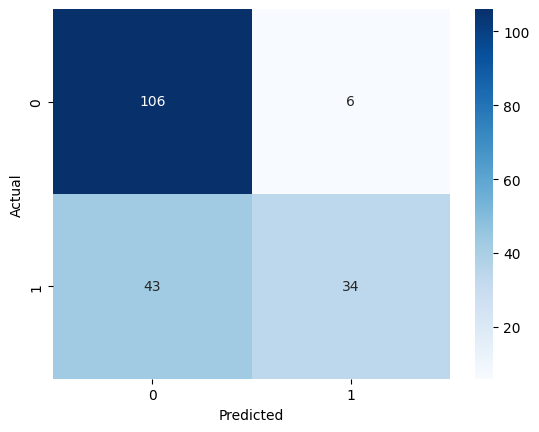

In [28]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = best_model.predict(X_test)
y_pred = np.round(y_pred).flatten()

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
